In [1]:
'''
This script goes and creates a 4x4 plot to look at the energy spectrum from each detector.
'''

#most likely comment these out if you aren't running this in Jupyterlab
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import os #used for file operations
import pickle #used for saving temporary results
import time

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [3]:
#specify the file directory you want to look at. This script will analyze ALL of the .bin files in this directory
fileDir = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/'
runName = 'After Second Set of HV Changes' #this determines the plot information and the output file name
#change the ordering of this around to match the proper set
#in the plotting the first 4 are the upper row, second 4 are the second row, etc
pixelList = [1, 12, 6, 2, 8, 13, 3, 4, 14, 5, 0, 7, 15, 9, 10, 11]
pixelNames = ['LaBr3: Channel 1', 'He-3: Channel 12', 'Channel 6', 'PMT-4: Channel 2',
              'Channel 8', 'Channel 13', 'PMT-5: Channel 3', 'PMT-6: Channel 4',
              'Channel 14', 'PMT-3: Channel 5', 'PMT-2: Channel 0', 'PMT-1: Channel 7',
              'Channel 15', 'PMT-7: Channel 9', 'PMT-12: Channel 10', 'PMT-8: Channel 11']
              
overwriteFiles = False #set this to true if you've already run this once and wnat to overwrite things
outputExtension = '.shortTrap'
#now set up the plotting energy ranges


In [4]:
#first define a bunch of commonly used functions
#this adjusts the waveform to have a 0 baseline and whatnot
def baselineShift(wave, window, flip = True):
    #flip the waveform over
    if flip:
        wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave, peak_sep, width):
    height = 30
    threshold = None
    distance = peak_sep
    prominence = None
    width = width
    wlen = None
    rel_height = None
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

decayrate = 90
length = 200
halfPoint = int(np.floor(length/2))
x = np.arange(length)
fitFunc = np.zeros(length)
fitFunc[halfPoint:] = np.exp(-1*x[:halfPoint] / decayrate)
const = np.ones(length)
linear = x[:]/np.max(x)
quad = np.square(linear)
fitFuncs = np.asarray([fitFunc, const, linear, quad])
fitFuncs = np.transpose(fitFuncs)
pinv = np.linalg.pinv(fitFuncs)
convolveFunc = np.flip(pinv[0])

def method1(wave):
    wave = wave.astype(np.float64)
    wave = wave[:]*-1
    wave = wave - np.mean(wave[:1000])
    fitResults = signal.convolve(wave, convolveFunc, mode='same')
    peaks, props = signal.find_peaks(fitResults, height = 20, 
                                     threshold = None,
                                     distance = length,
                                     width = None,
                                     wlen = None,
                                     rel_height = None,
                                     plateau_size = None)
    results = []
    for peak in peaks:
        results.append((peak, fitResults[peak]))
    return results

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames

def getAllFileNames(path, ext='.bin', overwrite = False, outputExtension = '.res'):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if ext in file:
                if ext == '.bin' and overwrite == False:
                    name, ext = os.path.splitext(os.path.join(r, file))
                    resultFile = name + outputExtension
                    if os.path.isfile(resultFile) == False:#if no result file add it to the list
                        files.append(os.path.join(r, file))
                else:
                    files.append(os.path.join(r, file))
                
    files.sort()
    return files

#this function finds the energy from one peak in the waveform
def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

#this function finds the energy from multiple peaks by calling the above function
def energyExtractionWave(wave, peaks, rise, top, threshold):
    energies = []
    for peak in peaks:
        energy = energyExtractionPeak(wave, peak, rise, top, threshold)
        energies.append(energy)
    return energies

def perWaveAnalysis(wave):
    enerRise = 90
    enerTop = 20
    enerTau = 90
    enerThreshold = 0.8
    #do the baseline shift
    wave = wave.astype(np.float64)
    hist, bins = np.histogram(wave, np.arange(0, 16384))
    averageVal = np.argmax(hist) #this gives the average baseline value pretty well
    wave = wave[:] - averageVal
    cleanwave = wave[:] * -1
    #use this to identify the peaks we care about, should make things a lot cleaner
    filtered = trapezoidalFilter(cleanwave, enerRise, enerTop, enerTau)
    peaks = findPeaks(filtered, enerRise*2 + enerTop, None)
    results = []
    for peak in peaks:
        if peak >= 500 and peak + 700 < len(cleanwave):
            energy = filtered[peak]-np.mean(filtered[int(peak-enerRise-enerTop-20):int(peak-enerRise-enerTop-10)])
            results.append((peak, energy))
    return results 

def perWavePowerSpec(wave):
    f, Pxx_den = signal.periodogram(wave, fs = 1E8)
    return Pxx_den

In [5]:
files = getAllFileNames(fileDir, overwrite = overwriteFiles, outputExtension=outputExtension) #find all the files to open

In [6]:
#actually do the analysis
runPixelList = np.arange(16)
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    for file in files:
        start = time.time()
        data = df.dataFile(file)
        nameNoExt, ext = os.path.splitext(file)
        outputFileName = nameNoExt+outputExtension
        fileResEner = []
        powerSpecs = []
        for p in range(len(runPixelList)):
            waves = data.getPixel(runPixelList[p])
            results = pool.map(method1, [wave for wave in waves])
            powerSpecRes = pool.map(perWavePowerSpec, [wave for wave in waves])
            powerSpecs.append(np.average(powerSpecRes, axis=0))
            fileResEner.append(results)
        with open(outputFileName, 'wb') as filehandle:
            # store the data as binary data stream
            pickle.dump([fileResEner, powerSpecs], filehandle)
        stop = time.time()
        print(file,files.index(file), len(files), stop - start, end="\r")

In [8]:
def loadResults(fileDir, outputExtension, runPixelList):
    resultFiles = getAllFileNames(fileDir, outputExtension)
    rawPixelValsEner = []
    rawPixelValsT0 = []
    for p in runPixelList:
        rawPixelValsEner.append([])
        rawPixelValsT0.append([])
    #now load these into memory
    for file in resultFiles:
        print('loading ', file, resultFiles.index(file), len(resultFiles), end="\r")
        with open(file, "rb") as f:
            res = pickle.load(f) #load this files results
            #grab the results for the pixel
            enert0res = res[0]
            for pixel in runPixelList:
                pixelRes = enert0res[pixel] #grabs the results for this pixel from all the waveforms
                for wave in pixelRes: #iterate over the different waveforms
                    for result in wave:
                        rawPixelValsEner[pixelList.index(pixel)].append(result[1])
                        rawPixelValsT0[pixelList.index(pixel)].append(result[0])    
    return rawPixelValsEner, rawPixelValsT0

In [9]:
#now go through and grab all of the result files and grab from memory
#if you have already done the analysis for this directory, skip to this point and start here
defaultHV = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/defaultHV/'
results = loadResults(defaultHV, outputExtension, runPixelList)

In [10]:
enerHists = []
enerHistBinsFixed = np.arange(0,400,1) #this ranges from 0 to 400 stepping by 1, adjust however you'd like
enerHistBins = []
for pixel in runPixelList:
    thisPixel = results[0][pixel]
    enerHist, bins = np.histogram(thisPixel, bins = enerHistBinsFixed)
    enerHists.append(enerHist)
    enerHistBins.append(bins)

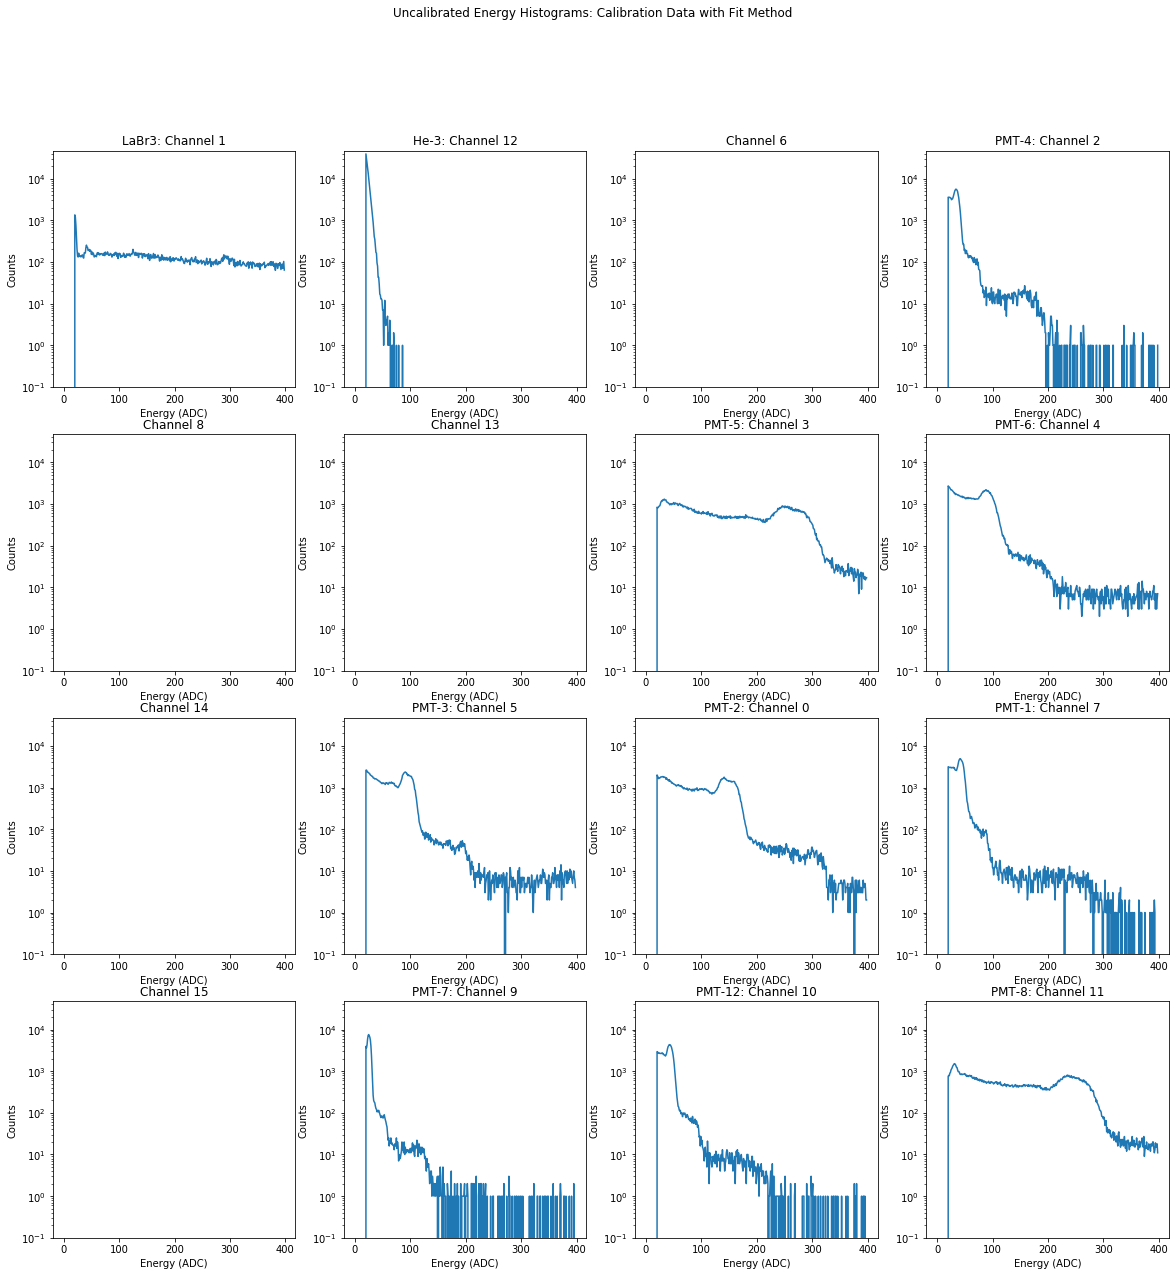

In [11]:
#now make the plots
#first figure out the plot range
minVal = 0.1
maxVal = 0
for hist in enerHists:
    if np.max(hist)>maxVal:
        maxVal = np.max(hist)
maxVal = maxVal * 1.2
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(20, 20)
for i in range(len(pixelList)):
    xCoord = int(i / 4)
    yCoord = i%4
    axs[xCoord, yCoord].plot(enerHistBins[i][:-1], enerHists[i])
    axs[xCoord, yCoord].set_title(pixelNames[i])
    axs[xCoord, yCoord].set_ylim(minVal, maxVal)
    axs[xCoord, yCoord].set_yscale('log')
    #axs[xCoord, yCoord].set_xscale('log')
for ax in axs.flat:
    ax.set(xlabel='Energy (ADC)', ylabel='Counts')
'''for ax in axs.flat:
    ax.label_outer()'''
fig.suptitle('Uncalibrated Energy Histograms: Calibration Data with Fit Method') 
plt.savefig('Uncalibrated Energy Histogram Calibration Data Fit Method.png')


In [11]:
powerHists = []
powerBins = np.abs(np.fft.fftfreq(500000)[:250001]*1E8)
for pixel in pixelList:
    thisPixel = []
    for res in results: #iterate over each result
        pixelRes = res[1][pixel] #grab the right pixel, the first 0 means grab the energy/timing information
        thisPixel.append(pixelRes)
    thisPixel = np.average(thisPixel, axis = 0)
    powerHists.append(thisPixel)

NameError: name 'powerHists' is not defined

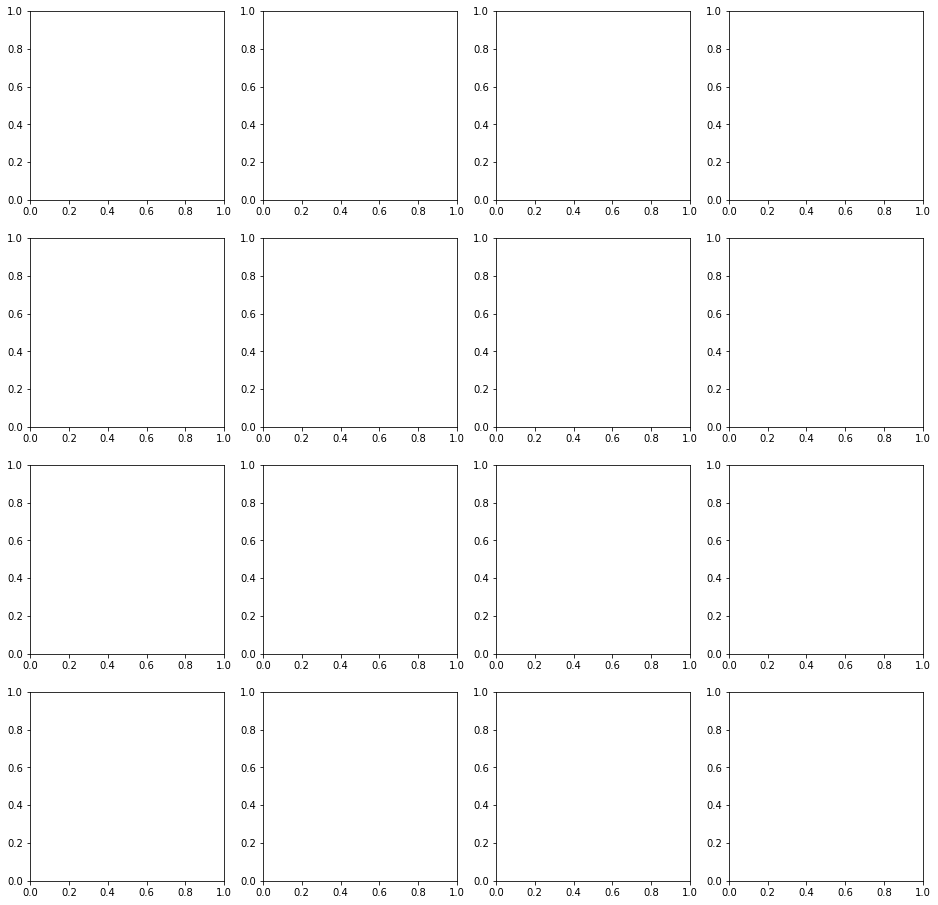

In [12]:
#now make the plots
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(16, 16)

maxVal = 0
minVal = 1
for hist in powerHists:
    if np.max(hist)>maxVal:
        maxVal = np.max(hist)
    if np.min(hist)<minVal:
        minVal = np.min(hist[1:])
maxVal *= 100
minVal /= 100
for i in range(len(pixelList)):
    xCoord = int(i / 4)
    yCoord = i%4
    axs[xCoord, yCoord].plot(powerBins, powerHists[i])
    axs[xCoord, yCoord].set_title(pixelNames[i])
    axs[xCoord, yCoord].set_yscale('log')
    axs[xCoord, yCoord].set_xscale('log')
    axs[xCoord, yCoord].set_ylim(minVal, maxVal)
for ax in axs.flat:
    ax.set(xlabel='Frequency (Hz)', ylabel='PSD (ADC^2 / Hz)')
for ax in axs.flat:
    ax.label_outer()
fig.suptitle(runName + ' Power Spectral Density') 
plt.savefig(runName+'powerSpec.png')


In [24]:
def grabMatchingIndexLoc(array, index):
    locs = np.where(array == index)
    return locs[0][0]

def gaussian(x, mu, sig, a, b):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + b


def fitPeak(hist, bins, peakLocGuess, fitwidth, peakwidth):
    #grab a piece of the array around this point
    #figure out where the guess location is in the array
    index = grabMatchingIndexLoc(bins, peakLocGuess)
    window = hist[index - fitwidth:index+fitwidth]
    windowbins = bins[index-fitwidth:index+fitwidth]
    guess = [peakLocGuess, peakwidth, np.max(window), np.min(window)]
    popt, pcov = optimize.curve_fit(gaussian, windowbins, window, p0=guess)
    plt.plot(windowbins, window)
    print(popt)
    plt.plot(windowbins, gaussian(windowbins, *popt))
    plt.show()
    return popt

In [100]:
calibratedPlotNames = [pixelNames[6], pixelNames[9], pixelNames[10], pixelNames[15]]
chanNums = [6, 9, 10, 15]
ms = []
bs = []
sigmas = []

PMT-5: Channel 3
[208.68752107   6.8938799  617.50662683 567.44790028]


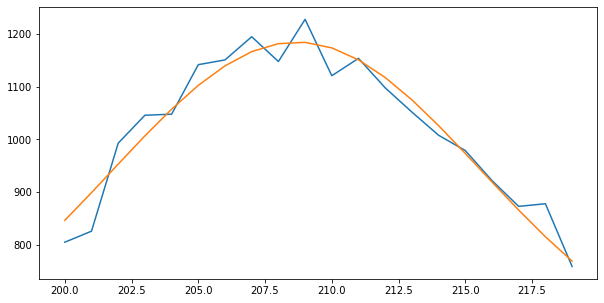

[235.60098887   8.22611746 687.12529853 255.71205299]


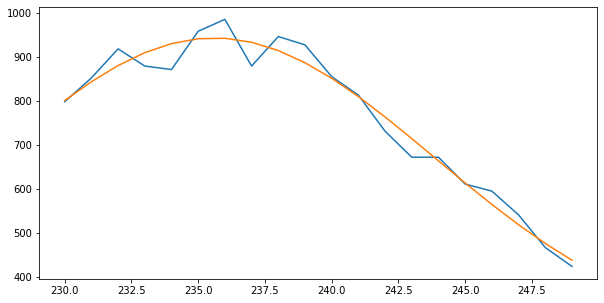

0.005917780688124684 -0.06172698204624868


In [101]:
#fitting Channel 2
chan = 6
pixelName = pixelNames[chan]
rawdata = rawPixelVals[chan]
print(pixelName)

bins = np.arange(170,300)
hist, bins = np.histogram(rawdata, bins)

peak1 = fitPeak(hist, bins, 210, 10, 10)
peak2 = fitPeak(hist, bins, 240, 10, 10)

dataPointsX = [peak1[0], peak2[0]]
dataPointsY = [1.173240, 1.332508]
m, b = np.polyfit(dataPointsX, dataPointsY, 1)
print(m, b)
ms.append(m)
bs.append(b)
sigmas.append(peak1[1]*m+b)

PMT-3: Channel 5


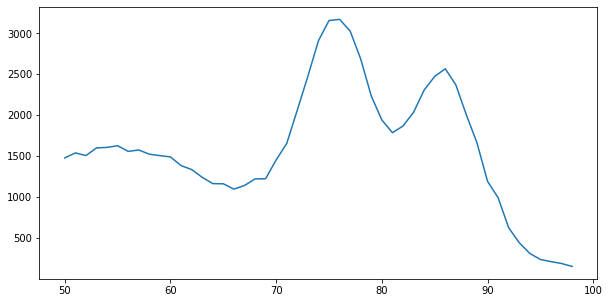

[  75.72043863    2.93450618 2096.33024863 1117.75923722]


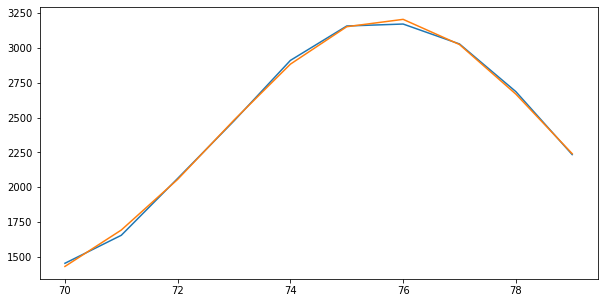

[  85.53215744    3.47975944 2294.84980275  247.79327374]


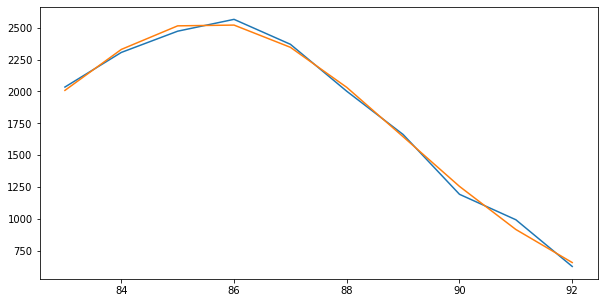

0.016232426039468652 -0.055886419712947485


In [102]:
chan = 9
pixelName = pixelNames[chan]
rawdata = rawPixelVals[chan]
print(pixelName)

bins = np.arange(50, 100)
hist, bins = np.histogram(rawdata, bins)
plt.plot(bins[:-1], hist)
plt.show()

peak1 = fitPeak(hist, bins, 75, 5, 5)
peak2 = fitPeak(hist, bins, 88, 5, 5)

dataPointsX = [peak1[0], peak2[0]]
dataPointsY = [1.173240, 1.332508]
m, b = np.polyfit(dataPointsX, dataPointsY, 1)
print(m, b)
ms.append(m)
bs.append(b)
sigmas.append(peak1[1]*m+b)

PMT-2: Channel 0


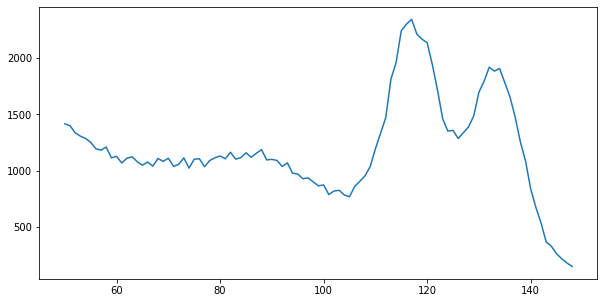

[ 1.17266661e+02  6.70695822e+01  2.39878391e+05 -2.37573052e+05]


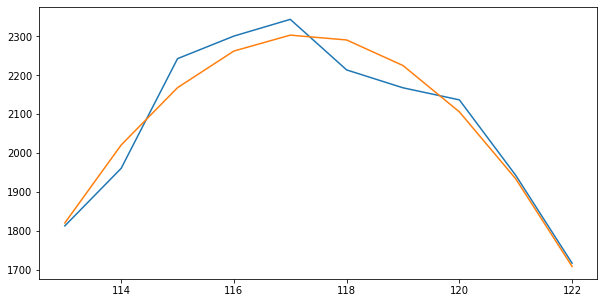

[ 132.87652995    5.41676201 1778.50052597  141.64232914]


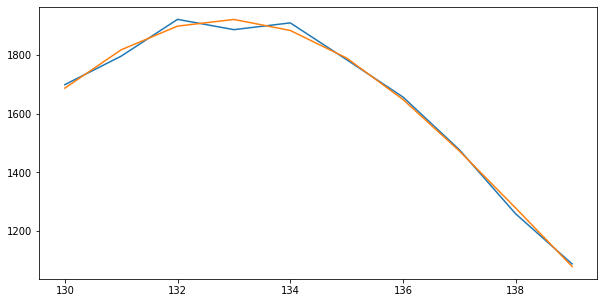

0.01020303280533275 -0.0232355941727522


In [103]:
chan = 10
pixelName = pixelNames[chan]
rawdata = rawPixelVals[chan]
print(pixelName)

bins = np.arange(50, 150)
hist, bins = np.histogram(rawdata, bins)
plt.plot(bins[:-1], hist)
plt.show()

peak1 = fitPeak(hist, bins, 118, 5, 5)
peak2 = fitPeak(hist, bins, 135, 5, 5)

dataPointsX = [peak1[0], peak2[0]]
dataPointsY = [1.173240, 1.332508]
m, b = np.polyfit(dataPointsX, dataPointsY, 1)
print(m, b)
ms.append(m)
bs.append(b)
sigmas.append(peak1[1]*m+b)

PMT-8: Channel 11


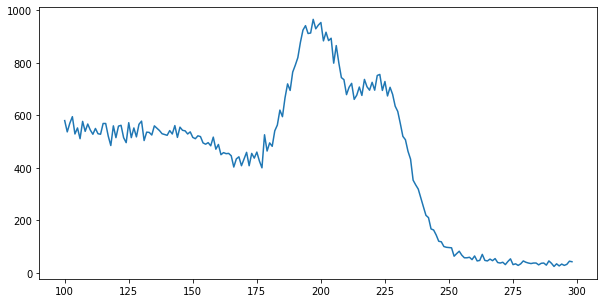

[198.09968815   2.08437935  61.18900815 889.35902812]


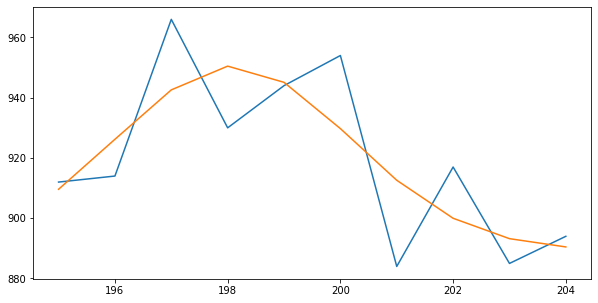

[   222.42350678    130.92373071  68477.77274455 -67747.69099551]


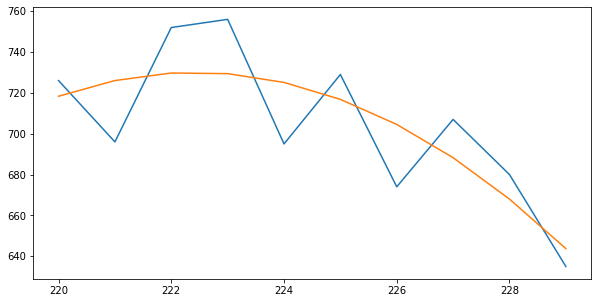

0.006547820569603123 -0.12388121288328059


In [104]:
chan = 15
pixelName = pixelNames[chan]
rawdata = rawPixelVals[chan]
print(pixelName)

bins = np.arange(100, 300)
hist, bins = np.histogram(rawdata, bins)
plt.plot(bins[:-1], hist)
plt.show()

peak1 = fitPeak(hist, bins, 200, 5, 5)
peak2 = fitPeak(hist, bins, 225, 5, 5)

dataPointsX = [peak1[0], peak2[0]]
dataPointsY = [1.173240, 1.332508]
m, b = np.polyfit(dataPointsX, dataPointsY, 1)
print(m, b)
ms.append(m)
bs.append(b)
sigmas.append(peak1[1]*m+b)

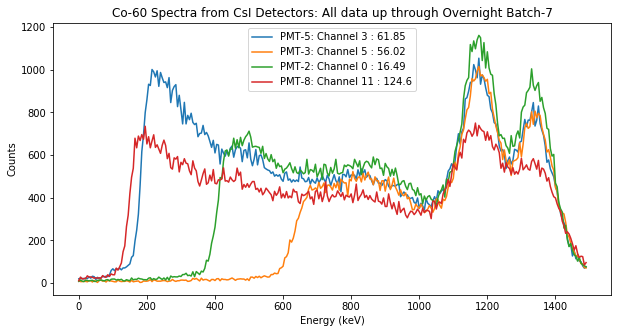

In [110]:
rcParams['figure.figsize'] = 10, 5
calibBins = np.arange(0, 1.5, 0.005)
for i in range(len(chanNums)):
    #first grab the raw data and scale it
    rawdata = np.array(rawPixelVals[chanNums[i]])
    rawdata = rawdata[:] * ms[i]+bs[i]
    hist, bins = np.histogram(rawdata, bins = calibBins)
    plt.plot(bins[:-1]*1000, hist, label=calibratedPlotNames[i]+' : '+str(round(abs((sigmas[i]*ms[i]+bs[i])*1000), 2)))

plt.title('Co-60 Spectra from CsI Detectors: All data up through Overnight Batch-7')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.legend()
plt.savefig('CalibratedCsISpectra.png')
plt.show()

In [79]:
print(len(ms))

4


In [59]:
def grabMatchingIndexLoc(array, index):
    locs = np.where(array == index)
    return locs[0][0]

pixelNum = 6
data = rawPixelVals[6]
histbins = np.arange(200, 300, 1)
hist, bins = np.histogram(data, bins = histbins)


peakLocs = [grabMatchingIndexLoc(bins, 237), grabMatchingIndexLoc(bins, 265)]

firstmean, firststd = fitPeak(hist, peakLocs[0], 10)
print(firstmean, firststd)
print(peakLocs)
plt.plot(bins[:-1], hist)
plt.show()

TypeError: fitPeak() missing 2 required positional arguments: 'fitwidth' and 'peakwidth'